In [198]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


from sklearn.metrics import roc_auc_score,roc_curve, auc
from sklearn.preprocessing import PowerTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from pycaret.classification import *


plt.rc('font', family='Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')


---   
## 데이터 불러오기

In [4]:
train=pd.read_csv('./train.csv',encoding='utf-8')
test=pd.read_csv('./test.csv',encoding='utf-8')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
# 학습용 데이터 레이블 분리하기
X=train[['PassengerId','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']]
Y=train.Survived

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [8]:
X.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

---   
### 컬럼별 확인 , 정리하기

In [ ]:
# 컬럼 정리하기 
# PassengerId - 삭제
# Pclass : 객실등급
# Name : 신분 확인 
# Sex : 라벨인코더 - 0/1 수정하기
# Age : null 약 20%
# SibSp :함께 탑승한 형제자매배우자 수
# Parch: 함께 탑승한 부모자녀 수
# Ticket:  티켓넘버 - 삭제
# Fare: 가격 - pclass와 관련 있을까? 
# Cabin : 객실번호? - null 많음 > 삭제?
# Embarked : 승선항 - 상관있을까? > null 2개 최빈값으로 우선 채워놓기
 


<AxesSubplot: >

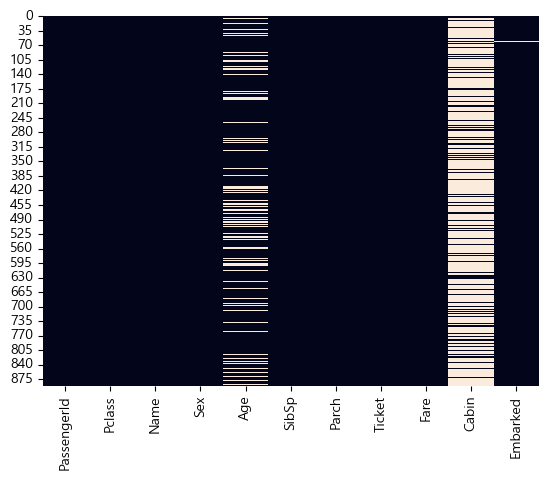

In [154]:
sns.heatmap(X.isnull(),cbar=False)

In [9]:
# null값이 많은 컬럼 삭제하기
del X['Cabin']
del test['Cabin']

In [10]:
# age는?
# age 컬럼 살펴보기
X.Age.value_counts()

24.00    30
22.00    27
18.00    26
19.00    25
28.00    25
         ..
36.50     1
55.50     1
0.92      1
23.50     1
74.00     1
Name: Age, Length: 88, dtype: int64

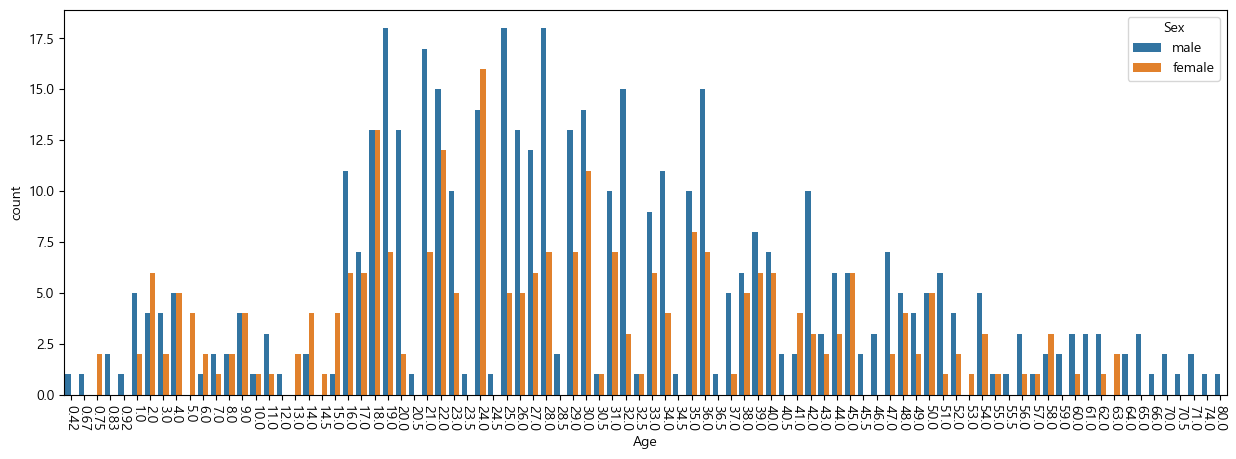

In [17]:
plt.figure(figsize=(15,5))
sns.countplot(data=X,x='Age',hue='Sex')
plt.xticks(rotation=270)
plt.show()

In [18]:
# Age가 null인 경우, 성별 최빈값/평균/중앙값 중 하나로 채우기

age_null=X[X.Age.isnull()]
age_null.Sex.value_counts()

male      124
female     53
Name: Sex, dtype: int64

In [19]:
# 최빈값 : 남성 3개나이 , 여성 1개나이
(X.Age[X.Sex=='male']).mode(), (X.Age[X.Sex=='female']).mode()

(0    19.0
 1    25.0
 2    28.0
 Name: Age, dtype: float64,
 0    24.0
 Name: Age, dtype: float64)

In [20]:
# 중앙값 : 
(X.Age[X.Sex=='male']).median(), (X.Age[X.Sex=='female']).median()

(29.0, 27.0)

In [21]:
# 평균
(X.Age[X.Sex=='male']).mean(), (X.Age[X.Sex=='female']).mean()

(30.72664459161148, 27.915708812260537)

<AxesSubplot: >

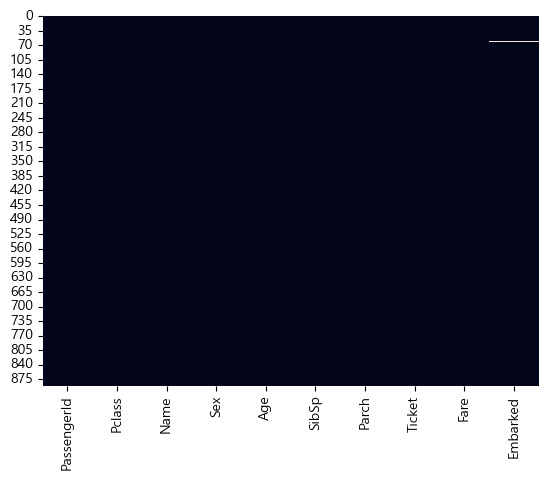

In [37]:
# 중앙값과 평균이 큰 차이가 없음 => 중앙값으로 채워보자

median_age_by_sex = X.groupby('Sex')['Age'].median()

# fill null values in age column with median age by sex
X['Age'] = X.apply(lambda x: median_age_by_sex[x['Sex']] if pd.isnull(x['Age']) else x['Age'], axis=1)

# Age컬럼 null확인
sns.heatmap(X.isnull(),cbar=False)

In [46]:
# Embarked null값 확인, 최빈값으로 채워놓기
X.Embarked.isnull().sum()

X.Embarked=X.Embarked.fillna(X.Embarked.mode()[0])
X.Embarked.isnull().sum()

0

In [ ]:
# test 데이터셋 null값 채우기

In [47]:
test.isnull().sum()

#age는 동일하게 성별 최빈값으로
#Fare는 데이터 정리후 채워보기

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Ticket          0
Fare            1
Embarked        0
dtype: int64

In [53]:
# test age 채우기

median_age = test.groupby('Sex')['Age'].median()

# fill null values in age column with median age by sex
test['Age'] = test.apply(lambda x: median_age[x['Sex']] if pd.isnull(x['Age']) else x['Age'], axis=1)

test.Age.isnull().sum()

0

In [130]:
#Fare가 nan인 값 1개
test[test.Fare.isnull()]

#60세 요금의 평균값?
#티켓번호 앞뒤의 평균값?

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S


In [54]:
#60세 요금 확인하기
test[(test.Age>=60) & (test.Age<61)]
#차이가 많음 > 동일 Pclass,Embarked,SibSp,Parch, 확인해보기


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
48,940,1,"Bucknell, Mrs. William Robert (Emma Eliza Ward)",female,60.0,0,0,11813,76.2917,C
69,961,1,"Fortune, Mrs. Mark (Mary McDougald)",female,60.0,1,4,19950,263.0000,S
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S
213,1105,2,"Howard, Mrs. Benjamin (Ellen Truelove Arman)",female,60.0,1,0,24065,26.0000,S


In [63]:
test[(test.Pclass==3)& (test.Embarked=='S') & (test.SibSp==0) &(test.Parch==0)]
#평균값 사용하기
mean=test[(test.Pclass==3)& (test.Embarked=='S') & (test.SibSp==0) &(test.Parch==0)].Fare.mean()
mean

9.339329670329667

---   
### 인코딩하기 : 성별, 승선지

In [69]:
# 성별: 라벨인코더 사용
le = LabelEncoder()
X.Sex = le.fit_transform(X.Sex)
test.Sex=le.fit_transform(test.Sex)

In [71]:
# 승선지: 라벨인코더 사용
X.Embarked.value_counts() #3개

X.Embarked=le.fit_transform(X.Embarked)
test.Embarked=le.fit_transform(test.Embarked)

In [72]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,2
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,1
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,2
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,2
...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",1,27.0,0,0,A.5. 3236,8.0500,2
414,1306,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,108.9000,0
415,1307,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTON/O.Q. 3101262,7.2500,2
416,1308,3,"Ware, Mr. Frederick",1,27.0,0,0,359309,8.0500,2


In [74]:
# PassengerId, Ticket > 컬럼 삭제하기
X.drop(columns=['Ticket','PassengerId'],axis=1, inplace=True)
test.drop(columns=['Ticket','PassengerId'],axis=1, inplace=True)
X

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,7.2500,2
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,71.2833,0
2,3,"Heikkinen, Miss. Laina",0,26.0,0,0,7.9250,2
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,53.1000,2
4,3,"Allen, Mr. William Henry",1,35.0,0,0,8.0500,2
...,...,...,...,...,...,...,...,...
886,2,"Montvila, Rev. Juozas",1,27.0,0,0,13.0000,2
887,1,"Graham, Miss. Margaret Edith",0,19.0,0,0,30.0000,2
888,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,27.0,1,2,23.4500,2
889,1,"Behr, Mr. Karl Howell",1,26.0,0,0,30.0000,0


---   
#### 새로운 특성 만들기 


In [75]:
# 이름으로 신분 조회 > Mr,  Miss, Rev,Mrs 등등

for idx, dataset in X.iterrows():
    print(dataset.Name)

Braund, Mr. Owen Harris
Cumings, Mrs. John Bradley (Florence Briggs Thayer)
Heikkinen, Miss. Laina
Futrelle, Mrs. Jacques Heath (Lily May Peel)
Allen, Mr. William Henry
Moran, Mr. James
McCarthy, Mr. Timothy J
Palsson, Master. Gosta Leonard
Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
Nasser, Mrs. Nicholas (Adele Achem)
Sandstrom, Miss. Marguerite Rut
Bonnell, Miss. Elizabeth
Saundercock, Mr. William Henry
Andersson, Mr. Anders Johan
Vestrom, Miss. Hulda Amanda Adolfina
Hewlett, Mrs. (Mary D Kingcome) 
Rice, Master. Eugene
Williams, Mr. Charles Eugene
Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)
Masselmani, Mrs. Fatima
Fynney, Mr. Joseph J
Beesley, Mr. Lawrence
McGowan, Miss. Anna "Annie"
Sloper, Mr. William Thompson
Palsson, Miss. Torborg Danira
Asplund, Mrs. Carl Oscar (Selma Augusta Emilia Johansson)
Emir, Mr. Farred Chehab
Fortune, Mr. Charles Alexander
O'Dwyer, Miss. Ellen "Nellie"
Todoroff, Mr. Lalio
Uruchurtu, Don. Manuel E
Spencer, Mrs. William Augustus (Marie E

In [80]:
import re

name2=[]
for idx, dataset in X.iterrows():
    temp=dataset.Name
    name2.append(re.search('\,\s\w+(\s\w+)?\.', temp).group()[2:-1])
    print(re.search('\,\s\w+(\s\w+)?\.', temp).group())


, Mr.
, Mrs.
, Miss.
, Mrs.
, Mr.
, Mr.
, Mr.
, Master.
, Mrs.
, Mrs.
, Miss.
, Miss.
, Mr.
, Mr.
, Miss.
, Mrs.
, Master.
, Mr.
, Mrs.
, Mrs.
, Mr.
, Mr.
, Miss.
, Mr.
, Miss.
, Mrs.
, Mr.
, Mr.
, Miss.
, Mr.
, Don.
, Mrs.
, Miss.
, Mr.
, Mr.
, Mr.
, Mr.
, Mr.
, Miss.
, Miss.
, Mrs.
, Mrs.
, Mr.
, Miss.
, Miss.
, Mr.
, Mr.
, Miss.
, Mr.
, Mrs.
, Master.
, Mr.
, Mrs.
, Mrs.
, Mr.
, Mr.
, Miss.
, Mr.
, Miss.
, Master.
, Mr.
, Miss.
, Mr.
, Master.
, Mr.
, Master.
, Mrs.
, Mr.
, Miss.
, Mr.
, Mr.
, Miss.
, Mr.
, Mr.
, Mr.
, Mr.
, Mr.
, Mr.
, Master.
, Miss.
, Mr.
, Mr.
, Miss.
, Mr.
, Miss.
, Mrs.
, Mr.
, Mr.
, Miss.
, Mr.
, Mr.
, Mr.
, Mr.
, Mr.
, Mr.
, Mr.
, Mr.
, Mr.
, Mrs.
, Mr.
, Miss.
, Mr.
, Mr.
, Mr.
, Mr.
, Mr.
, Miss.
, Mr.
, Mr.
, Miss.
, Mr.
, Miss.
, Mr.
, Miss.
, Miss.
, Mr.
, Mr.
, Mr.
, Mr.
, Miss.
, Mr.
, Mr.
, Mr.
, Miss.
, Mr.
, Master.
, Mr.
, Mr.
, Miss.
, Mr.
, Mr.
, Mr.
, Mrs.
, Mrs.
, Mr.
, Mr.
, Miss.
, Mr.
, Mr.
, Mr.
, Mrs.
, Miss.
, Mrs.
, Mr.
, Mr.
, Mr.
, Mr

In [83]:
#컬럼 만들기 
X['Name2']=name2
X.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Name2
0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,7.2500,2,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,71.2833,0,Mrs
2,3,"Heikkinen, Miss. Laina",0,26.0,0,0,7.9250,2,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,53.1000,2,Mrs
4,3,"Allen, Mr. William Henry",1,35.0,0,0,8.0500,2,Mr


In [86]:
#test 데이터셋 수정

name2=[]
for idx, dataset in test.iterrows():
    temp=dataset.Name
    name2.append(re.search('\,\s\w+(\s\w+)?\.', temp).group()[2:-1])
test['Name2']=name2
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Name2
0,3,"Kelly, Mr. James",1,34.5,0,0,7.8292,1,Mr
1,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,7.0000,2,Mrs
2,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,9.6875,1,Mr
3,3,"Wirz, Mr. Albert",1,27.0,0,0,8.6625,2,Mr
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,12.2875,2,Mrs


In [85]:
pd.crosstab(X.Name2, X.Sex)


Sex,0,1
Name2,,
Capt,0,1
Col,0,2
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40
Miss,182,0


In [97]:
test.Name2.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

In [88]:
X.Name2.unique()
# 여성 호칭 : Lady Miss Mlle  Mme Mrs Ms  the Countess (Dr 제외)
# 남성 호칭 : Capt Col Don	Dr	Jonkheer Major Master	 Mr Rev Sir	

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [96]:
# rare 호칭 분리
rare_f=['Lady','Mlle','Mme','Ms','the Countess'] 
rare_m=['Capt','Col','Don','Dr','Jonkheer','Major','Master','Rev','Sir']

In [103]:
dr_idx=X[(X.Name2=='Dr')& (X.Sex==0)].Name2.index[0]

In [119]:
for i in rare_f:
    X.Name2=X.Name2.replace(i,'rare_f')
X[X.Sex=='female'].Name2.replace('Dr','rare_f')

for i in rare_m:
    X.Name2=X.Name2.replace(i,'rare_m')

In [123]:
X.Name2.unique()

array(['Mr', 'Mrs', 'Miss', 'rare_m', 'rare_f'], dtype=object)

In [127]:
#test 데이터셋
pd.crosstab(test.Name2,test.Sex)


Sex,0,1
Name2,,
Col,0,2
Dona,1,0
Dr,0,1
Master,0,21
Miss,78,0
Mr,0,240
Mrs,72,0
Ms,1,0
Rev,0,2


In [129]:
rare_f=['Dona','Ms']
rare_m=['Col','Dr','Master','Rev']

for i in rare_f:
    test.Name2=test.Name2.replace(i,'rare_f')

for i in rare_m:
    test.Name2=test.Name2.replace(i,'rare_m')

test.Name2.unique()

array(['Mr', 'Mrs', 'Miss', 'rare_m', 'rare_f'], dtype=object)

In [132]:
X.info()
#Name 삭제, name2인코딩 하기

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    int32  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    int32  
 8   Name2     891 non-null    object 
dtypes: float64(2), int32(2), int64(3), object(2)
memory usage: 55.8+ KB


In [137]:
del X['Name']
del test['Name']
test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Name2
0,3,1,34.5,0,0,7.8292,1,Mr
1,3,0,47.0,1,0,7.0000,2,Mrs
2,2,1,62.0,0,0,9.6875,1,Mr
3,3,1,27.0,0,0,8.6625,2,Mr
4,3,0,22.0,1,1,12.2875,2,Mrs
...,...,...,...,...,...,...,...,...
413,3,1,27.0,0,0,8.0500,2,Mr
414,1,0,39.0,0,0,108.9000,0,rare_f
415,3,1,38.5,0,0,7.2500,2,Mr
416,3,1,27.0,0,0,8.0500,2,Mr


In [141]:
# name2 컬럼 정리 :
no_r_f=['Mrs', 'Miss']
X.Name2=X.Name2.replace(no_r_f,'normal_f')
test.Name2=test.Name2.replace(no_r_f,'normal_f')


In [192]:
X

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,N
0,3,1,22.0,1,0,7.2500,2,normal_m
1,1,0,38.0,1,0,71.2833,0,normal_f
2,3,0,26.0,0,0,7.9250,2,normal_f
3,1,0,35.0,1,0,53.1000,2,normal_f
4,3,1,35.0,0,0,8.0500,2,normal_m
...,...,...,...,...,...,...,...,...
886,2,1,27.0,0,0,13.0000,2,rare_m
887,1,0,19.0,0,0,30.0000,2,normal_f
888,3,0,27.0,1,2,23.4500,2,normal_f
889,1,1,26.0,0,0,30.0000,0,normal_m


In [199]:
# name2(신분) 원핫인코딩
X_ohe=pd.get_dummies(X) 
X_ohe

test_ohe=pd.get_dummies(test) 
test_ohe


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,N_normal_f,N_normal_m,N_rare_f,N_rare_m
0,3,1,34.5,0,0,7.8292,1,0,1,0,0
1,3,0,47.0,1,0,7.0000,2,1,0,0,0
2,2,1,62.0,0,0,9.6875,1,0,1,0,0
3,3,1,27.0,0,0,8.6625,2,0,1,0,0
4,3,0,22.0,1,1,12.2875,2,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
413,3,1,27.0,0,0,8.0500,2,0,1,0,0
414,1,0,39.0,0,0,108.9000,0,0,0,1,0
415,3,1,38.5,0,0,7.2500,2,0,1,0,0
416,3,1,27.0,0,0,8.0500,2,0,1,0,0


In [400]:
# name2(신분) 라벨인코딩
le=LabelEncoder()
X.N=le.fit_transform(X.N)
test.N=le.fit_transform(test.N)

In [401]:
test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,N
0,3,1,34.5,0,0,7.8292,1,1
1,3,0,47.0,1,0,7.0000,2,0
2,2,1,62.0,0,0,9.6875,1,1
3,3,1,27.0,0,0,8.6625,2,1
4,3,0,22.0,1,1,12.2875,2,0
...,...,...,...,...,...,...,...,...
413,3,1,27.0,0,0,8.0500,2,1
414,1,0,39.0,0,0,108.9000,0,2
415,3,1,38.5,0,0,7.2500,2,1
416,3,1,27.0,0,0,8.0500,2,1


In [402]:
X

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,N
0,3,1,22.0,1,0,7.2500,2,1
1,1,0,38.0,1,0,71.2833,0,0
2,3,0,26.0,0,0,7.9250,2,0
3,1,0,35.0,1,0,53.1000,2,0
4,3,1,35.0,0,0,8.0500,2,1
...,...,...,...,...,...,...,...,...
886,2,1,27.0,0,0,13.0000,2,3
887,1,0,19.0,0,0,30.0000,2,0
888,3,0,27.0,1,2,23.4500,2,0
889,1,1,26.0,0,0,30.0000,0,1


In [205]:
X_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      891 non-null    int64  
 1   Sex         891 non-null    int64  
 2   Age         891 non-null    float64
 3   SibSp       891 non-null    int64  
 4   Parch       891 non-null    int64  
 5   Fare        891 non-null    float64
 6   Embarked    891 non-null    int64  
 7   N_normal_f  891 non-null    uint8  
 8   N_normal_m  891 non-null    uint8  
 9   N_rare_f    891 non-null    uint8  
 10  N_rare_m    891 non-null    uint8  
dtypes: float64(2), int64(5), uint8(4)
memory usage: 52.3 KB


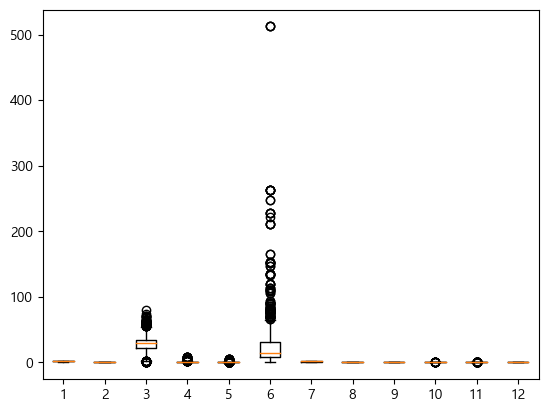

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
       'N_normal_f', 'N_normal_m', 'N_rare_f', 'N_rare_m', 'Y'],
      dtype='object')

In [214]:
# 컬럼별 범위
plt.boxplot(X_ohe)
plt.show()
X_ohe.columns

#나이, Fare 범위 큼 > 인코딩 

In [215]:
test_ohe

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,N_normal_f,N_normal_m,N_rare_f,N_rare_m
0,3,1,34.5,0,0,7.8292,1,0,1,0,0
1,3,0,47.0,1,0,7.0000,2,1,0,0,0
2,2,1,62.0,0,0,9.6875,1,0,1,0,0
3,3,1,27.0,0,0,8.6625,2,0,1,0,0
4,3,0,22.0,1,1,12.2875,2,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
413,3,1,27.0,0,0,8.0500,2,0,1,0,0
414,1,0,39.0,0,0,108.9000,0,0,0,1,0
415,3,1,38.5,0,0,7.2500,2,0,1,0,0
416,3,1,27.0,0,0,8.0500,2,0,1,0,0


In [216]:
#PowerTransformer : 정규분포와 유사하게 scaling
scaler = PowerTransformer()

X_pt_sc = scaler.fit_transform(X_ohe.iloc[:,:-1])
test_pt_sc = scaler.fit_transform(test_ohe)


In [219]:
X_pt_sc=pd.DataFrame(X_pt_sc,columns=X_ohe.columns[:-1])
test_pt_sc=pd.DataFrame(test_pt_sc,columns=test_ohe.columns)


In [220]:
X_pt_sc

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,N_normal_f,N_normal_m,N_rare_f,N_rare_m
0,0.863973,0.737695,-0.530948,1.373636,-0.560253,-0.878820,0.610411,-0.725041,0.850532,-0.121681,-0.254000
1,-1.459129,-1.355574,0.678418,1.373636,-0.560253,1.336651,-1.780520,1.379232,-1.175735,-0.121681,-0.254000
2,0.863973,-1.355574,-0.215865,-0.679850,-0.560253,-0.790065,0.610411,1.379232,-1.175735,-0.121681,-0.254000
3,-1.459129,-1.355574,0.460874,1.373636,-0.560253,1.067352,0.610411,1.379232,-1.175735,-0.121681,-0.254000
4,0.863973,0.737695,0.460874,-0.679850,-0.560253,-0.774439,0.610411,-0.725041,0.850532,-0.121681,-0.254000
...,...,...,...,...,...,...,...,...,...,...,...
886,-0.592604,0.737695,-0.138628,-0.679850,-0.560253,-0.294907,0.610411,-0.725041,-1.175735,-0.121681,3.937004
887,-1.459129,-1.355574,-0.774614,-0.679850,-0.560253,0.527906,0.610411,1.379232,-1.175735,-0.121681,-0.254000
888,0.863973,-1.355574,-0.138628,1.373636,1.846856,0.288885,0.610411,1.379232,-1.175735,-0.121681,-0.254000
889,-1.459129,0.737695,-0.215865,-0.679850,-0.560253,0.527906,-1.780520,-0.725041,0.850532,-0.121681,-0.254000


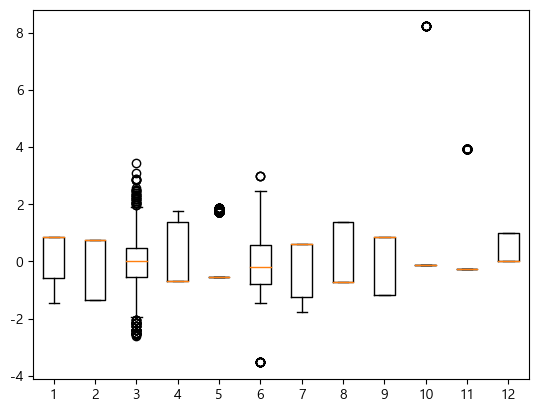

In [233]:
plt.boxplot(X_pt_sc)
plt.show()

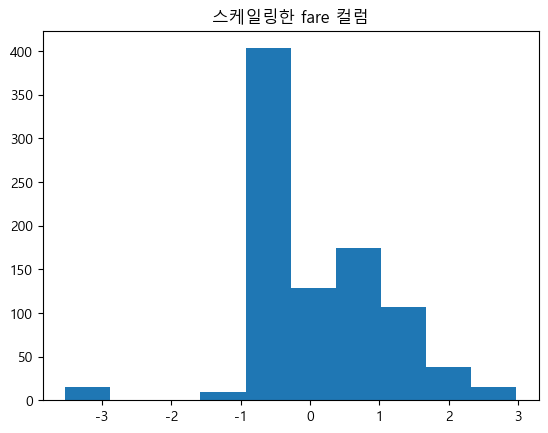

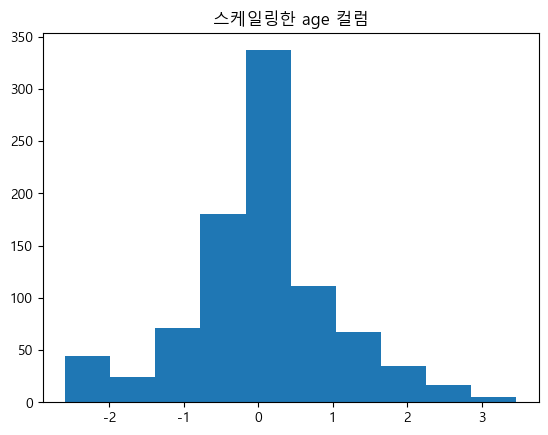

In [225]:
plt.hist(X_pt_sc.Fare)
plt.title('스케일링한 fare 컬럼')
plt.show()

plt.hist(X_pt_sc.Age)
plt.title('스케일링한 age 컬럼')
plt.show()

In [165]:
x_pt=pd.read_csv('./1st.csv')

In [230]:
X_pt_sc['Y']=Y

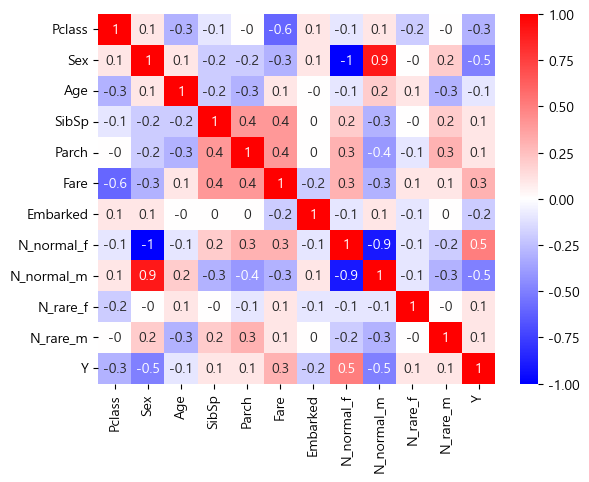

In [231]:
#상관관계
sns.heatmap(data=X_pt_sc.corr().round(1), annot=True, cmap='bwr')
plt.show()

# Y와 높은 상관관계 없음, 우선 모든 컬럼 사용하기

---   
### 분류 모델링
- 1. 의사결정

In [ ]:
#PowerTransformer : 정규분포와 유사하게 scaling
scaler = PowerTransformer()

X_pt_sc = scaler.fit_transform(x_le)
test_pt_sc = scaler.fit_transform(test_le)

X_pt_sc=pd.DataFrame(X_pt_sc,columns=x_le.columns)
test_pt_sc=pd.DataFrame(test_pt_sc,columns=test_le.columns)


In [183]:
# 원핫인코딩1.
dt2=DecisionTreeClassifier(max_depth=3, random_state=156)
dt2.fit(X_train,y_train)

pred=dt2.predict(X_test)
auc_score2 = roc_auc_score(y_test, pred)

print(f'AUC : {auc_score2} \n feature importance : {dt2.feature_importances_}')


AUC : 0.7715476190476191 
 feature importance : [0.19267147 0.61744786 0.07209322 0.04399684 0.         0.07379061
 0.         0.        ]


In [177]:
# 라벨인코딩1
X_train,X_test, y_train,y_test= train_test_split(X_pt_sc,y2,test_size=0.3, random_state=156)

dt3=DecisionTreeClassifier(max_depth=4, random_state=156)
dt3.fit(X_train,y_train)

pred=dt3.predict(X_test)
auc_score3 = roc_auc_score(y_test, pred)

print(f'AUC : {auc_score3} \n feature importance : {dt3.feature_importances_}')

AUC : 0.7675000000000001 
 feature importance : [0.18509389 0.57302175 0.12035513 0.04083121 0.         0.08069801
 0.         0.        ]


In [196]:
# 라벨인코딩2

dt4=DecisionTreeClassifier(max_depth=6, random_state=156)
dt4.fit(X_train,y_train)

pred=dt4.predict(X_test)
auc_score4 = roc_auc_score(y_test, pred)

print(f'AUC : {auc_score4} \n feature importance : {dt4.feature_importances_}')

AUC : 0.7966666666666667 
 feature importance : [0.15911843 0.49260578 0.14758238 0.03651257 0.         0.15823722
 0.00126077 0.00468285]


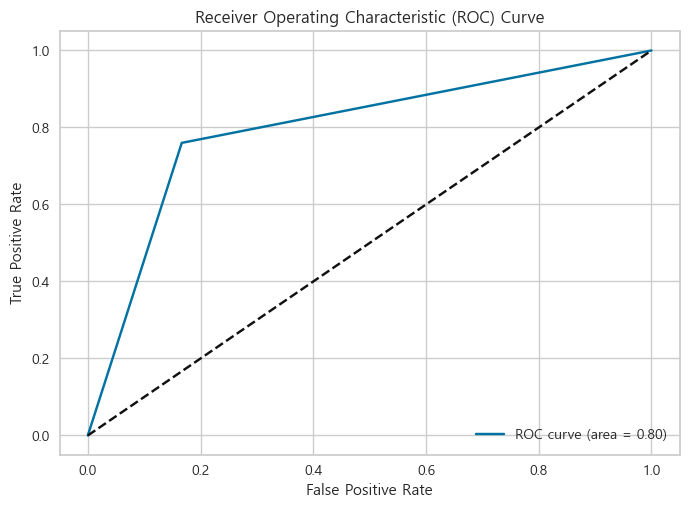

In [199]:
# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, pred)

# Compute the area under the curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Add a diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [391]:
X.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'N'], dtype='object')

---   
### 분류 모델링
- 2. 랜덤포레스트 

In [204]:
X_train,X_test, y_train,y_test= train_test_split(X_pt_sc,y2,test_size=0.3, random_state=156)

rf1=RandomForestClassifier(n_estimators=200, random_state=156)
rf1.fit(X_train,y_train)

pred=rf1.predict(X_test)
auc_score1 = roc_auc_score(y_test, pred)

print(f'AUC : {auc_score1} \n feature importance : {rf1.feature_importances_}')

AUC : 0.8035714285714286 
 feature importance : [0.07864803 0.17675078 0.23770775 0.05047307 0.03955014 0.24835422
 0.02967801 0.138838  ]


In [395]:
rf1=RandomForestClassifier(n_estimators=200, random_state=156)
rf1.fit(X_train,y_train)

pred=rf1.predict(X_test)
auc_score1 = roc_auc_score(y_test, pred)

print(f'AUC : {auc_score1} \n feature importance : {rf1.feature_importances_}')

AUC : 0.8324459093982423 
 feature importance : [0.08931633 0.15782708 0.23657555 0.05348308 0.03207749 0.26840609
 0.02967436 0.13264001]


In [397]:
rf2=RandomForestClassifier(n_estimators=200,
                          max_depth=15,
                          min_samples_leaf=5,
                          min_samples_split=12, 
                          random_state=156)
rf2.fit(X_train,y_train)

pred=rf2.predict(X_test)
auc_score2 = roc_auc_score(y_test, pred)

print(f'AUC : {auc_score2} \n feature importance : {rf2.feature_importances_}')

AUC : 0.8310513860716701 
 feature importance : [0.13708082 0.27197985 0.10902865 0.03978724 0.01857736 0.1738311
 0.02550695 0.22420804]


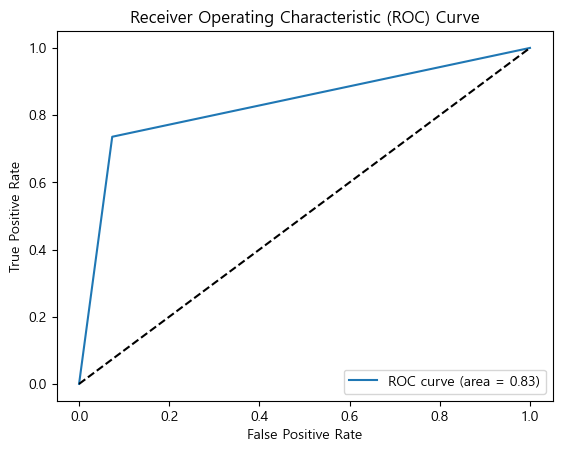

In [398]:
fpr, tpr, thresholds = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Add a diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [406]:
#라벨인코딩 + 랜덤포레스트
rf3=RandomForestClassifier(n_estimators=200,
                          max_depth=15,
                          min_samples_leaf=5,
                          min_samples_split=12, 
                          random_state=156)
rf3.fit(X,Y)
pred=rf3.predict(test)
pred


array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [408]:
mission=pd.read_csv('./submission.csv',encoding='utf-8')
mission.Survived=pred
mission.to_csv('./1st.csv',encoding='utf-8',index=False)

---   
#### 다른 모델 찾아보기


In [4]:
x_le=pd.read_csv('./X_le.csv',encoding='utf-8')
test_le=pd.read_csv('./test_le.csv',encoding='utf-8')

In [6]:
x=pd.read_csv('./train.csv',encoding='utf-8')

In [17]:
x_le['y']=x.Survived
x_le

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,N,y
0,3,1,22.0,1,0,7.2500,2,1,0
1,1,0,38.0,1,0,71.2833,0,0,1
2,3,0,26.0,0,0,7.9250,2,0,1
3,1,0,35.0,1,0,53.1000,2,0,1
4,3,1,35.0,0,0,8.0500,2,1,0
...,...,...,...,...,...,...,...,...,...
886,2,1,27.0,0,0,13.0000,2,3,0
887,1,0,19.0,0,0,30.0000,2,0,1
888,3,0,27.0,1,2,23.4500,2,0,0
889,1,1,26.0,0,0,30.0000,0,1,1


In [19]:
from pycaret.classification import *
py_try=setup(data=x_le,target='y',session_id=123)

,Description,Value
0,session_id,123
1,Target,y
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(891, 9)"
5,Missing Values,False
6,Numeric Features,2
7,Categorical Features,6
8,Ordinal Features,False
9,High Cardinality Features,False


In [20]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8187,0.8541,0.7335,0.7912,0.7601,0.6147,0.6170,0.0240
ridge,Ridge Classifier,0.8171,0.0000,0.7503,0.7771,0.7627,0.6140,0.6152,0.0030
lda,Linear Discriminant Analysis,0.8171,0.8577,0.7462,0.7792,0.7616,0.6134,0.6146,0.0050
lr,Logistic Regression,0.8155,0.8581,0.7585,0.7702,0.7631,0.6122,0.6135,0.4770
ada,Ada Boost Classifier,0.8059,0.8456,0.7665,0.7521,0.7568,0.5955,0.5983,0.0230
lightgbm,Light Gradient Boosting Machine,0.7946,0.8575,0.7085,0.7587,0.7304,0.5649,0.5680,0.0110
rf,Random Forest Classifier,0.7881,0.8539,0.7175,0.7405,0.7256,0.5536,0.5569,0.0550
dt,Decision Tree Classifier,0.7834,0.7816,0.7377,0.7227,0.7274,0.5480,0.5508,0.0030
et,Extra Trees Classifier,0.7785,0.8273,0.7057,0.7348,0.7141,0.5341,0.5400,0.0510
svm,SVM - Linear Kernel,0.7094,0.0000,0.4828,0.7107,0.5192,0.3442,0.3718,0.0030


In [30]:
x_le.groupby(by='y').count()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,N
y,,,,,,,,
0,549,549,549,549,549,549,549,549
1,342,342,342,342,342,342,342,342


In [83]:
#로지스틱회귀, 그레디언트 부스트 사용해보기
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import StratifiedKFold

In [66]:
#StratifiedKFold 사용위해 array변경
X = x_le[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'N']].values
y = x_le['y'].values

In [57]:
#로지스틱+ 교차검증

lr = LogisticRegression()

skfold=StratifiedKFold(n_splits=4)
n_iter=0
cv_auc=[]

features=X
label=y

for train_i, test_i in skfold.split(features,label):
    x_train,x_test=features[train_i], features[test_i]
    y_train, y_test= label[train_i],label[test_i]

    lr.fit(x_train, y_train)
    pred=lr.predict(x_test)

    #auc 측정
    n_iter+=1
    auc = roc_auc_score(y_test, pred)
    
    print('\n # {0}회차 - 교차검증 AUC : {1}'.format(n_iter, auc))
    cv_auc.append(auc)

#평균
print(f'\n 교차검증별 정확도: {cv_auc} , 평균 : {np.mean(cv_auc)}')
    

#기대보다 낮은듯? 하이퍼 파라미터 수정하기 + 그래디언트 부스트 사용해보기


 # 1회차 - 교차검증 AUC : 0.7913469735720375

 # 2회차 - 교차검증 AUC : 0.8180274995756237

 # 3회차 - 교차검증 AUC : 0.771515871668647

 # 4회차 - 교차검증 AUC : 0.8063117217689996

 교차검증별 정확도: [0.7913469735720375, 0.8180274995756237, 0.771515871668647, 0.8063117217689996] , 평균 : 0.796800516646327


In [55]:
# 그래디언트 부스트 + 교차검증

gbc = GradientBoostingClassifier()

skfold=StratifiedKFold(n_splits=4)
n_iter=0
cv_auc=[]

for train_i, test_i in skfold.split(features,label):
    x_train,x_test=features[train_i], features[test_i]
    y_train, y_test= label[train_i],label[test_i]

    gbc.fit(x_train, y_train)
    pred=lr.predict(x_test)

    #auc 측정
    n_iter+=1
    auc = roc_auc_score(y_test, pred)
    
    print('\n # {0}회차 - 교차검증 AUC : {1}'.format(n_iter, auc))
    cv_auc.append(auc)

#평균
print(f'\n 교차검증별 정확도: {cv_auc} , 평균 : {np.mean(cv_auc)}')
    

# 로지스틱, 그래디언트 큰 차이 없음 'N'컬럼 빼고 해볼까?


 # 1회차 - 교차검증 AUC : 0.7972293265132141

 # 2회차 - 교차검증 AUC : 0.8070785944661347

 # 3회차 - 교차검증 AUC : 0.7824647767781361

 # 4회차 - 교차검증 AUC : 0.8063117217689996

 교차검증별 정확도: [0.7972293265132141, 0.8070785944661347, 0.7824647767781361, 0.8063117217689996] , 평균 : 0.7982711048816211


In [60]:
X2= x_le[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']].values


In [65]:
#

lr = LogisticRegression()

skfold=StratifiedKFold(n_splits=4)
n_iter=0
cv_auc=[]

features=X2
label=y

print('\n로지스틱 회귀')
for train_i, test_i in skfold.split(features,label):
    x_train,x_test=features[train_i], features[test_i]
    y_train, y_test= label[train_i],label[test_i]

    lr.fit(x_train, y_train)
    pred=lr.predict(x_test)

    #auc 측정
    n_iter+=1
    auc = roc_auc_score(y_test, pred)
    
    print(' # {0}회차 - 교차검증 AUC : {1}'.format(n_iter, auc))
    cv_auc.append(auc)

#평균
print(f'\n 교차검증별 정확도: {cv_auc} , 평균 : {np.mean(cv_auc)}')
    


print('\n로지스틱 회귀')
gbc = GradientBoostingClassifier()

skfold=StratifiedKFold(n_splits=4)
n_iter=0
cv_auc=[]

for train_i, test_i in skfold.split(features,label):
    x_train,x_test=features[train_i], features[test_i]
    y_train, y_test= label[train_i],label[test_i]

    gbc.fit(x_train, y_train)
    pred=lr.predict(x_test)

    #auc 측정
    n_iter+=1
    auc = roc_auc_score(y_test, pred)
    
    print('# {0}회차 - 교차검증 AUC : {1}'.format(n_iter, auc))
    cv_auc.append(auc)

#평균
print('\n그래디언트 부스트')
print(f'\n 교차검증별 정확도: {cv_auc} , 평균 : {np.mean(cv_auc)}')
    
#n컬럼은 있는게 나은듯


로지스틱 회귀
 # 1회차 - 교차검증 AUC : 0.7718670076726343
 # 2회차 - 교차검증 AUC : 0.7997793243931421
 # 3회차 - 교차검증 AUC : 0.7424461042267866
 # 4회차 - 교차검증 AUC : 0.7900815800772865

 교차검증별 정확도: [0.7718670076726343, 0.7997793243931421, 0.7424461042267866, 0.7900815800772865] , 평균 : 0.7760435040924624

로지스틱 회귀
# 1회차 - 교차검증 AUC : 0.7650895140664962
# 2회차 - 교차검증 AUC : 0.8012646409777627
# 3회차 - 교차검증 AUC : 0.7635375997283994
# 4회차 - 교차검증 AUC : 0.7900815800772865

그래디언트 부스트

 교차검증별 정확도: [0.7650895140664962, 0.8012646409777627, 0.7635375997283994, 0.7900815800772865] , 평균 : 0.7799933337124861


In [84]:
#하이퍼파라미터수정 > optuna사용
import optuna
from optuna.samplers import TPESampler

In [146]:
X_train,X_test,y_train,y_test=train_test_split(x_le, y2, test_size=0.3, random_state=156)

In [149]:
def objective(trial):
    gbc_model =GradientBoostingClassifier(learning_rate=trial.suggest_float("learning_rate", 0.05, 0.1), 
                                     n_estimators=trial.suggest_int("n_estimators", 100, 200),
                                     max_depth=trial.suggest_int("depth", 4, 6),
                                     min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
                                     min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
                                     verbose=False
                                     )
    gbc_model.fit(X_train, y_train)
    y_pred = gbc_model.predict(X_test)
    return roc_auc_score(y_test, y_pred)

In [150]:
#그래디언트 부스트 하이퍼파라미터 수정
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="gbc_opt",
    direction="minimize",
    sampler=sampler
)
study.optimize(objective, n_trials=200)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-03-06 19:37:02,646] A new study created in memory with name: gbc_opt
[I 2023-03-06 19:37:02,863] Trial 0 finished with value: 0.8104761904761905 and parameters: {'learning_rate': 0.06872700594236814, 'n_estimators': 196, 'depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8104761904761905.
[I 2023-03-06 19:37:02,970] Trial 1 finished with value: 0.8154761904761904 and parameters: {'learning_rate': 0.05779972601681013, 'n_estimators': 105, 'depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8104761904761905.
[I 2023-03-06 19:37:03,202] Trial 2 finished with value: 0.8284523809523809 and parameters: {'learning_rate': 0.05102922471479013, 'n_estimators': 197, 'depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8104761904761905.
[I 2023-03-06 19:37:03,317] Trial 3 finished with value: 0.8015476190476191 and parameters: {'learning_rate': 0.059170225492671695, 'n_estimato

Best Score: 0.7835714285714286
Best trial: {'learning_rate': 0.09675608670109259, 'n_estimators': 170, 'depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 1}


In [154]:
test_le.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,N
0,3,1,34.5,0,0,7.8292,1,1
1,3,0,47.0,1,0,7.0000,2,0
2,2,1,62.0,0,0,9.6875,1,1
3,3,1,27.0,0,0,8.6625,2,1
4,3,0,22.0,1,1,12.2875,2,0


In [155]:
gbc_model =GradientBoostingClassifier(learning_rate=0.0967, 
                                     n_estimators=170,
                                     max_depth=4,
                                     min_samples_split=6,
                                     min_samples_leaf=1,
                                     verbose=False)
gbc_model.fit(x_le, y2)
y_pred = gbc_model.predict(test_le)


In [158]:
sub=pd.read_csv('./submission.csv',encoding='utf-8')
sub.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [162]:
sub['Survived']=y_pred

In [163]:
sub.to_csv('./sub3.csv',encoding='utf-8',index=False)